In [3]:
from dieboldmariano import dm_test
import utils.DataSplitter
from utils.metrics import *
from utils.ColumnEnum import Columns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
level = 60
line = Columns.line_1A.value
target = Columns.target_passengersBoarding.value

if level == 60:
    agg = 1
elif level == 30:
    agg = 2
elif level == 15:
    agg = 4

df_level = utils.DataSplitter.getTrainData(agglevel=level, diff=False)
df_level_line = df_level[df_level['line'] == line]
df_train, df_val = utils.DataSplitter.performTrainValSplit(df=df_level_line)

to_drop = [target]
X_train = utils.DataSplitter.subsetColumns(df_train, dropCategorical=True, dropLags=True, dropWeather=False, dropCalendar=False, 
                                           dropSpecific=to_drop)
y_train = df_train[target]

X_val = utils.DataSplitter.subsetColumns(df_val, dropCategorical=True, dropLags=True, dropWeather=False, dropCalendar=False, 
                                         dropSpecific=to_drop)
y_val = df_val[target]

print(all(X_train.columns == X_val.columns))
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
print(X_train.columns)

True
(14680, 29) (14680,) (1840, 29) (1840,)
Index(['peakHour', 'Q1', 'Q2', 'Q3', 'Q4', 'mon', 'tue', 'wed', 'thu', 'fri',
       'sat', 'sun', 'workdayPlan', 'saturdayPlan', 'sundayAndHolidayPlan',
       'summerVacation', 'fallVacation', 'christmasVacation', 'winterVacation',
       'easterVacation', 'acc_precip', 'bright_sunshine', 'mean_cloud_cover',
       'mean_pressure', 'mean_relative_hum', 'mean_temp', 'mean_wind_speed',
       'snow_depth', 'event'],
      dtype='object')


In [78]:
SNaive_preds = np.load("predictions/1ASNaive_validation_predictions.npy").tolist()
Lasso_preds = np.load("predictions/1ALCW_Lasso_validation_predictions.npy").tolist()
RF_preds = np.load("predictions/1ALCW_RF_validation_predictions.npy").tolist()
XGB_preds = np.load("predictions/1ALC_XGB_validation_predictions.npy").tolist()
RNN_preds = np.load("predictions/1ALC_RNN_validation_predictions.npy").tolist()
LSTM_preds = np.load("predictions/1ALC_LSTM_validation_predictions.npy").tolist()

all_preds = [SNaive_preds, Lasso_preds, RF_preds, XGB_preds, RNN_preds, LSTM_preds]
all_preds_names = ["Seasonal Naive", "Lasso", "Random Forest Regression", "XGBoost", "Vanilla RNN", "LSTM"]

# Plot of Predictions vs Ground Truth

In [94]:
import matplotlib.pyplot as plt

def plotPredsAgainstGT(all_preds, names, gt):

    fig, ax = plt.subplots(3, 2, figsize=(10, 8))
    fig.set_tight_layout('h_pad')

    line_values = np.linspace(-10000, 10000, 100)
    
    for i, preds in enumerate(all_preds):
        j = 1 if i >= 3 else 0
        ax[i%3, j].scatter(preds, gt, color="steelblue")
        ax[i%3, j].plot(line_values, line_values, color="black")
        ax[i%3, j].set_xlim(-60, max(preds)+max(preds)//20)
        ax[i%3, j].set_ylim(-60, max(gt)+max(gt)//20)
        ax[i%3, j].set_xlabel("Predicted")
        ax[i%3, j].set_ylabel("GT")
        ax[i%3, j].set_title(names[i])
    
    plt.tight_layout()
    plt.show()

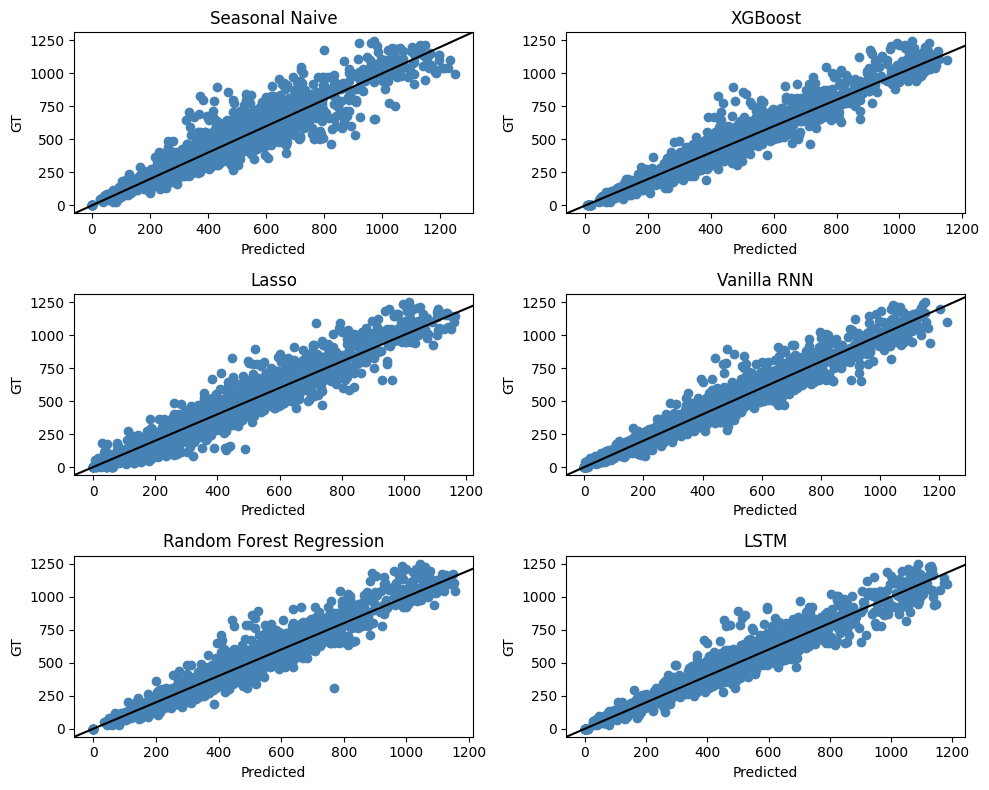

In [95]:
plotPredsAgainstGT(all_preds, all_preds_names, df_val["passengersBoarding"])

# Diebold Mariano

In [5]:
dm_test(y_val.tolist(), SNaive_preds, Lasso_preds)

(5.423635720149243, 6.612288610755604e-08)

# Residual analysis

In [6]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

In [7]:
def adf_test(series, alpha=0.05, hypothesis=False):
    # Extract test statistic and p-value
    test_statistic, p_value, _, _, _, _ = adfuller(series)
    if hypothesis:
        print("H_0: Time Series is not stationary")
        print("H_A: Time Series is stationary")
    if p_value < alpha:
        print(f"p-value: {p_value} < {alpha} (Stationary)")
    if p_value > alpha:
        print(f"p-value: {p_value} > {alpha} (Not Stationary)")
    if p_value == alpha:
        print(f"p-value: {p_value} = {alpha}")
    return test_statistic, p_value

def kpss_test(series, alpha=0.05, hypothesis=False):
    # Extract test statistic and p-value
    test_statistic, p_value, lags, _ = kpss(series)
    if hypothesis:
        print("H_0: Time Series is stationary")
        print("H_A: Time Series is not stationary")
    if p_value < alpha:
        print(f"p-value: {p_value} < {alpha} (Not Stationary)")
    if p_value > alpha:
        print(f"p-value: {p_value} > {alpha} (Stationary)")
    if p_value == alpha:
        print(f"p-value: {p_value} = {alpha}")
    print(f"lags: {lags}")
    return test_statistic, p_value, lags

p-value: 2.1928782871802073e-07 < 0.05 (Stationary)
p-value: 0.1 > 0.05 (Stationary)
lags: 22


C:\Users\asa\AppData\Local\Temp\ipykernel_25484\2409044522.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  test_statistic, p_value, lags, _ = kpss(series)


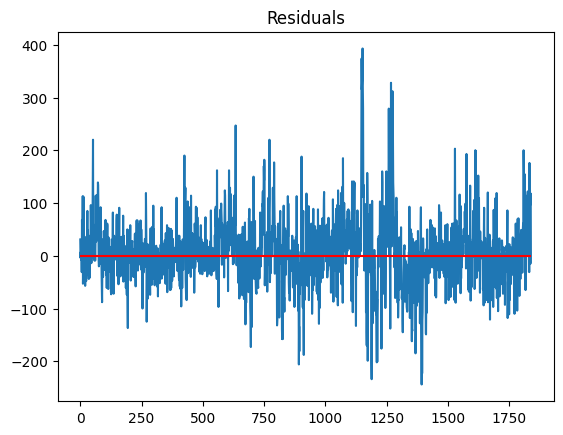

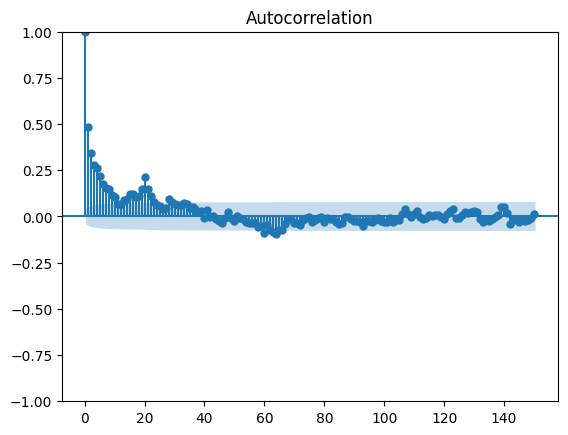

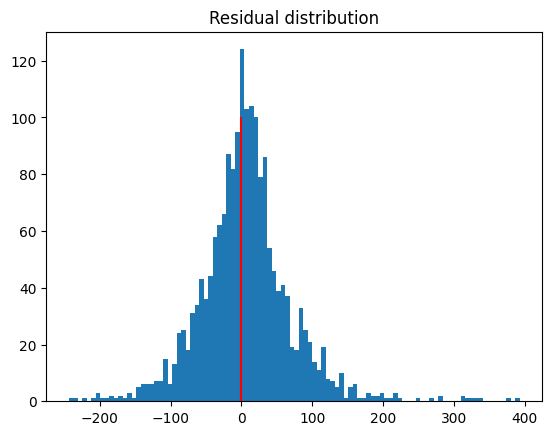

In [8]:
residuals = y_val.to_numpy() - np.array(LSTM_preds)
adf_test(residuals)
kpss_test(residuals)

plt.plot(residuals)
plt.title('Residuals')
plt.hlines(y=0, xmin=0, xmax=residuals.shape[0], colors='red')
plt.show()

plot_acf(residuals, lags=150, alpha=0.05)
plt.show()

plt.hist(residuals, bins=100)
plt.title('Residual distribution')
plt.vlines(x=0, ymin=0, ymax=100, colors='red')
plt.show()

# Forecast Horizon Analysis

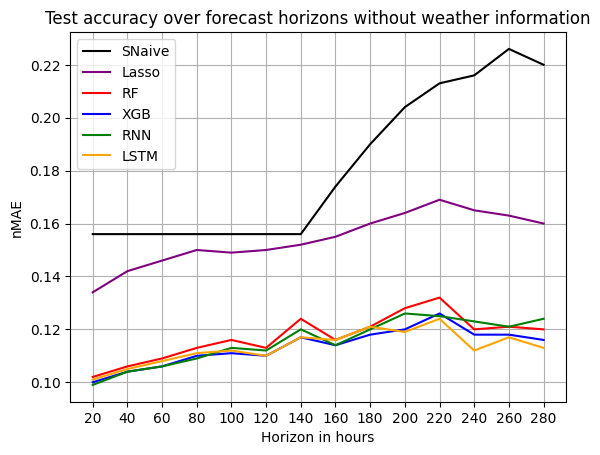

In [5]:
# line 1A on test data without weather
horizons = np.array([i for i in range(20, 280+1, 20)])
SNaive_nMAE = np.array([0.156, 0.156, 0.156, 0.156, 0.156, 0.156, 0.156, 0.174, 0.190, 0.204, 0.213, 0.216, 0.226, 0.220])
Lasso_nMAE = np.array([0.134, 0.142, 0.146, 0.150, 0.149, 0.150, 0.152, 0.155, 0.160, 0.164, 0.169, 0.165, 0.163, 0.160])
RF_nMAE = np.array([0.102, 0.106, 0.109, 0.113, 0.116, 0.113, 0.124, 0.116, 0.121, 0.128, 0.132, 0.120, 0.121, 0.120])
XGB_nMAE = np.array([0.100, 0.104, 0.106, 0.110, 0.111, 0.110, 0.117, 0.114, 0.118, 0.120, 0.126, 0.118, 0.118, 0.116])
RNN_nMAE = np.array([0.099, 0.104, 0.106, 0.109, 0.113, 0.112, 0.120, 0.114, 0.120, 0.126, 0.125, 0.123, 0.121, 0.124])
LSTM_nMAE = np.array([0.101, 0.105, 0.108, 0.111, 0.112, 0.110, 0.117, 0.116, 0.121, 0.119, 0.124, 0.112, 0.117, 0.113])

plt.title('Test accuracy over forecast horizons without weather information')
plt.plot(horizons, SNaive_nMAE, '-', color='black', label='SNaive')
plt.plot(horizons, Lasso_nMAE, '-', color='purple', label='Lasso')
plt.plot(horizons, RF_nMAE, '-', color='red', label='RF')
plt.plot(horizons, XGB_nMAE, '-', color='blue', label='XGB')
plt.plot(horizons, RNN_nMAE, '-', color='green', label='RNN')
plt.plot(horizons, LSTM_nMAE, '-', color='orange', label='LSTM')
plt.legend()
plt.grid()
plt.xlabel('Horizon in hours')
plt.ylabel('nMAE')
plt.xticks(horizons)
plt.show()